In [10]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/question2/emotions.zip'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/question2/emotions.zip
replace fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fer2013.csv             
replace fer2013/fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fer2013/fer2013.csv     


In [12]:
import pandas as pd
import cv2 as cv
import numpy as np
import math
df = pd.read_csv('fer2013.csv')
df.head()
df.Usage.value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


In [13]:
y_train = df[df.Usage=='Training'].pixels
y_valid = df[df.Usage=='PrivateTest'].pixels
y_test = df[df.Usage=='PublicTest'].pixels


def extract_photo(x):
  data = np.array([int(val) for val in x.split()])
  dimention = int(math.sqrt(len(data)))
  data = data.reshape(dimention, dimention)
  return data


y_train = y_train.apply(extract_photo).tolist()
y_train = np.stack(y_train, axis=0)

y_valid = y_valid.apply(extract_photo).tolist()
y_valid = np.stack(y_valid, axis=0)

y_test = y_test.apply(extract_photo).tolist()
y_test = np.stack(y_test, axis=0)



def add_gaussian_noise(image, mean=0, sigma=10):
    noise = np.random.normal(mean, sigma, image.shape).astype('int32')
    noisy_image = cv.add(image, noise)
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

x_train = np.zeros_like(y_train)
x_valid = np.zeros_like(y_valid)
x_test = np.zeros_like(y_test)

for i in range(y_train.shape[0]):
    x_train[i] = add_gaussian_noise(y_train[i])

for i in range(y_valid.shape[0]):
    x_valid[i] = add_gaussian_noise(y_valid[i])

for i in range(y_test.shape[0]):
    x_test[i] = add_gaussian_noise(y_test[i])

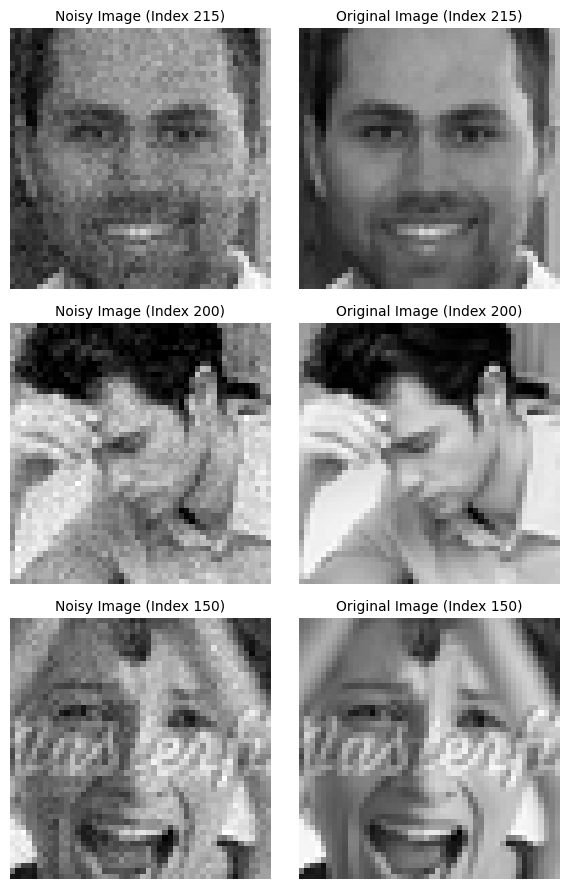

In [22]:
import matplotlib.pyplot as plt



indices = [215, 200, 150]
fig, axes = plt.subplots(3, 2, figsize=(6, 9))

for i, index in enumerate(indices):
    axes[i, 0].imshow(x_train[index], cmap=plt.cm.binary_r)
    axes[i, 0].set_title(f"Noisy Image (Index {index})", fontsize=10)
    axes[i, 0].axis('off')
    axes[i, 0].set_aspect('equal')


    axes[i, 1].imshow(y_train[index], cmap=plt.cm.binary_r)
    axes[i, 1].set_title(f"Original Image (Index {index})", fontsize=10)
    axes[i, 1].axis('off')
    axes[i, 1].set_aspect('equal')

plt.tight_layout()
plt.show()


x_train = x_train / 255.0
x_valid = x_valid / 255.0
x_test = x_test / 255.0
y_train = y_train / 255.0
y_valid = y_valid / 255.0
y_test = y_test / 255.0

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
def unet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1_1 = layers.Conv2D(32, 1, activation='relu', padding='same')(inputs)
    conv1_2 = layers.Conv2D(32, 1, activation='relu', padding='same')(conv1_1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1_2)

    conv2_1 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2_1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2_2)


    conv3_1 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3_2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3_1)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3_2)

    conv4_1 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4_2 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv4_1)
    up1 = layers.UpSampling2D(size=(2, 2))(conv4_2)
    concated1 = layers.Concatenate()([up1, conv3_2])
   
    con_up_1_1 = layers.Conv2D(128, 3, activation='relu', padding='same')(concated1)
    con_up_1_2 = layers.Conv2D(128, 3, activation='relu', padding='same')(con_up_1_1)
    up2 = layers.UpSampling2D(size=(2, 2))(con_up_1_2)
    concated2 = layers.Concatenate()([up2, conv2_2])

    con_up_2_1 = layers.Conv2D(64, 3, activation='relu', padding='same')(concated2)
    con_up_2_2 = layers.Conv2D(64, 3, activation='relu', padding='same')(con_up_2_1)
    up3 = layers.UpSampling2D(size=(2, 2))(con_up_2_2)
    concated3 = layers.Concatenate()([up3, conv1_2])
    
    con_up_3_1 = layers.Conv2D(32, 3, activation='relu', padding='same')(concated3)
    con_up_3_2 = layers.Conv2D(32, 3, activation='relu', padding='same')(con_up_3_1)

    outputs = layers.Conv2D(1, 1, activation=None)(con_up_3_2)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (48, 48, 1)
model = unet(input_shape)

model.summary()



early_stop = 5
earlyStop = EarlyStopping(monitor='val_loss', patience=early_stop, verbose=1, mode='auto')

check_point_name = 'best_weight.keras'
check_point = ModelCheckpoint(filepath = check_point_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='MeanSquaredError', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data = (x_valid, y_valid), callbacks=[earlyStop, check_point],
          verbose=1)

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_acc}')
model_output = model.predict(x_test)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 48, 48, 32)     │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 48, 48, 32)     │          1,056 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 24, 24, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 24, 24, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 24, 24, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 12, 12, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 12, 12, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 12, 12, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 6, 6, 128)      │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 6, 6, 256)      │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 6, 6, 256)      │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 12, 12, 256)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 12, 12, 384)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 12, 12, 128)    │        442,496 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 12, 12, 128)    │        147,584 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 24, 24, 128)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)       

 Total params: 1,937,857 (7.39 MB)

 Trainable params: 1,937,857 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0068 - loss: 7.9409e-07
Epoch 1: val_loss improved from inf to 0.00000, saving model to best_weight.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.0068 - loss: 7.9369e-07 - val_accuracy: 0.0071 - val_loss: 1.8059e-07
Epoch 2/25
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0072 - loss: 1.6098e-07
Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to best_weight.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.0072 - loss: 1.6095e-07 - val_accuracy: 0.0071 - val_loss: 1.2592e-07
Epoch 3/25
896/898 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0068 - loss: 1.1658e-07
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to best_weight.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.0068 - loss: 1.1656e-07 - val_accuracy: 0.0071 - val_loss: 9.9851e-08
Epoch 4/25
895/898 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0072 - loss: 9.4388e-08
E

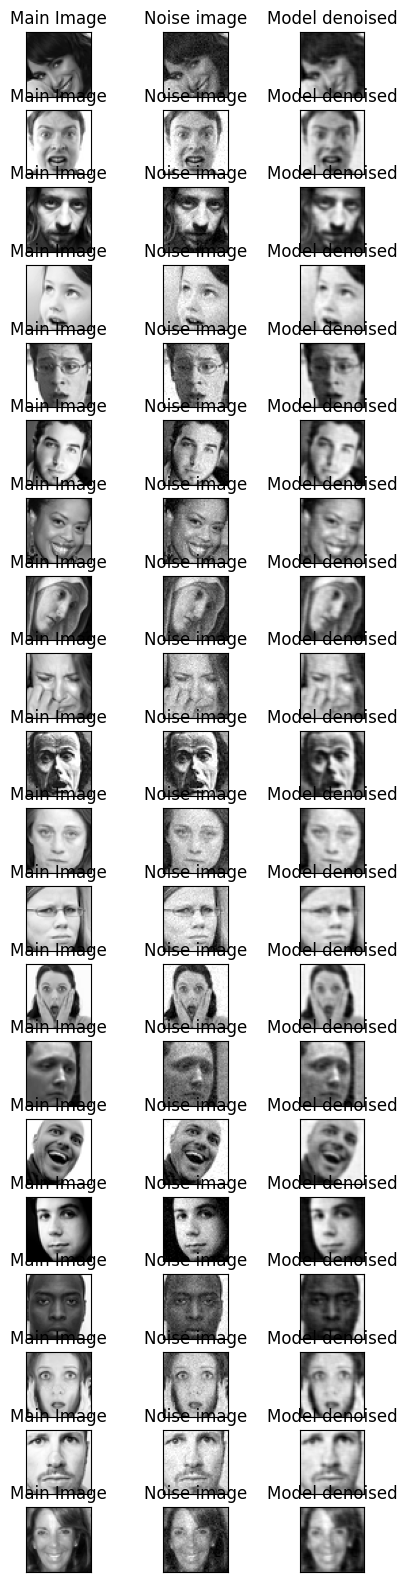

In [24]:
np.random.seed(20)

indices = np.random.randint(0, y_test.shape[0], size=20)

fig = plt.figure(figsize=(5, 20))

for i, index in enumerate(indices):
  plt.subplot(20, 3, i*3 + 1, xticks=[], yticks=[])
  plt.imshow(y_test[index], cmap=plt.cm.binary_r), plt.title('Main Image')
  plt.subplot(20, 3, i*3 + 2, xticks=[], yticks=[])
  plt.imshow(x_test[index], cmap=plt.cm.binary_r), plt.title('Noise image')
  plt.subplot(20, 3, i*3 + 3, xticks=[], yticks=[])
  plt.imshow(model_output[index], cmap=plt.cm.binary_r), plt.title('Model denoised')